In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import hockey.hockey_env as h_env

from rl_hockey.DDDQN import DDDQN
from rl_hockey.common import utils

In [19]:
env = h_env.HockeyEnv(mode=h_env.Mode.TRAIN_SHOOTING)

o_space = env.observation_space
# DDDQN uses discrete actions (7 or 8 depending on keep_mode)
discrete_action_dim = 7 if not env.keep_mode else 8

In [20]:
max_episodes = 500
max_episode_steps = 500
updates_per_step = 1
warmup_steps = 10000

In [21]:
agent = DDDQN(o_space.shape[0], action_dim=discrete_action_dim)

In [22]:
losses = []
rewards = []
steps = 0
gradient_steps = 0

In [23]:
run_name = 'hockey-shooting-ddqn'

In [24]:
pbar = tqdm(range(max_episodes), desc=run_name)
for i in pbar:    
    total_reward = 0
    state, _ = env.reset()

    agent.on_episode_start(i)

    for t in range(max_episode_steps):
        done = False
        # Get discrete action from DDDQN
        discrete_action = agent.act(state.astype(np.float32))
        
        # Convert discrete action to continuous for player 1
        action_p1 = env.discrete_to_continous_action(discrete_action)
        # Player 2 uses zero action (static opponent)
        action_p2 = np.zeros(len(action_p1))
        # Combine actions for both players
        action = np.hstack([action_p1, action_p2])
        
        (next_state, reward, done, trunc, _) = env.step(action)
        
        # Store transition with discrete action as numpy array for buffer compatibility
        discrete_action_array = np.array([discrete_action], dtype=np.float32)
        agent.store_transition((state, discrete_action_array, reward, next_state, done))
        # Store mirrored transition
        agent.store_transition((utils.mirror_state(state), discrete_action_array, reward, utils.mirror_state(next_state), done))
        
        state = next_state

        steps += 1
        total_reward += reward

        if steps >= warmup_steps / 2:  # mirroring enables 2 transitions per step
            stats = agent.train(updates_per_step)

            gradient_steps += updates_per_step
            losses.extend(stats['loss'])

        if done or trunc:
            break

    agent.on_episode_end(i)

    rewards.append(total_reward)    
    
    pbar.set_postfix({
        'total_reward': total_reward,
        'episode_length': t,
        'eps': agent.config['eps'],
    })

agent.save(f'../../../models/dddqn/{run_name}_{gradient_steps//1000}k.pt')

hockey-shooting-ddqn:  15%|█▌        | 76/500 [00:07<00:43,  9.70it/s, total_reward=3.07, episode_length=64, eps=0.963]  


KeyboardInterrupt: 

In [ ]:
def moving_average(data, window_size):
    moving_averages = []
    for i in range(len(data)):
        window_start = max(0, i - window_size + 1)
        window = data[window_start:i + 1]
        moving_averages.append(sum(window) / len(window))
    
    return moving_averages

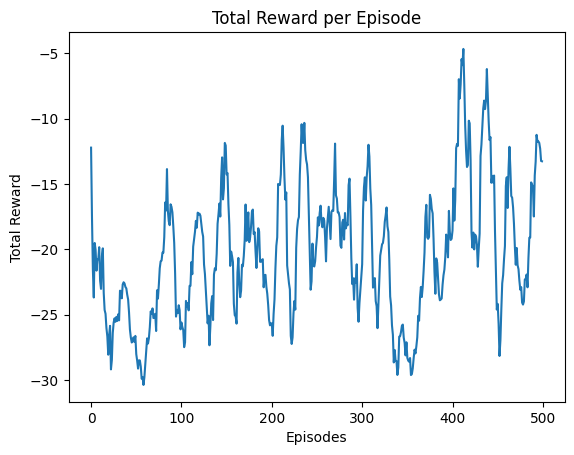

In [ ]:
plt.plot(moving_average(rewards, 10))
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()

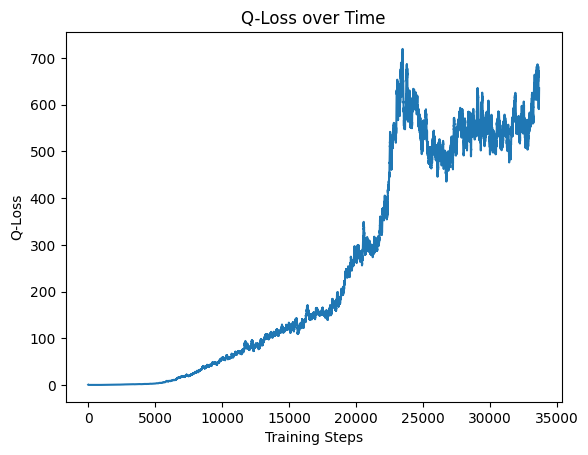

In [ ]:
plt.plot(moving_average(losses, 100))
plt.xlabel('Training Steps')
plt.ylabel('Q-Loss')
plt.title('Q-Loss over Time')
plt.show()

In [ ]:
env = h_env.HockeyEnv(mode=h_env.Mode.TRAIN_SHOOTING)

In [ ]:
total_reward = 0
state, _ = env.reset()
for t in range(max_episode_steps):
    env.render(mode="human")

    done = False
    # Get discrete action deterministically (no epsilon exploration)
    discrete_action = agent.act(state.astype(np.float32), deterministic=True)
    
    # Convert to continuous action
    action_p1 = env.discrete_to_continous_action(discrete_action)
    action_p2 = np.zeros(len(action_p1))
    action = np.hstack([action_p1, action_p2])
    
    (next_state, reward, done, trunc, _) = env.step(action)
    state = next_state

    total_reward += reward

    if done or trunc:
        break

print(f'total_reward: {total_reward}')

total_reward: -19.61828317018018


In [ ]:
env.close()